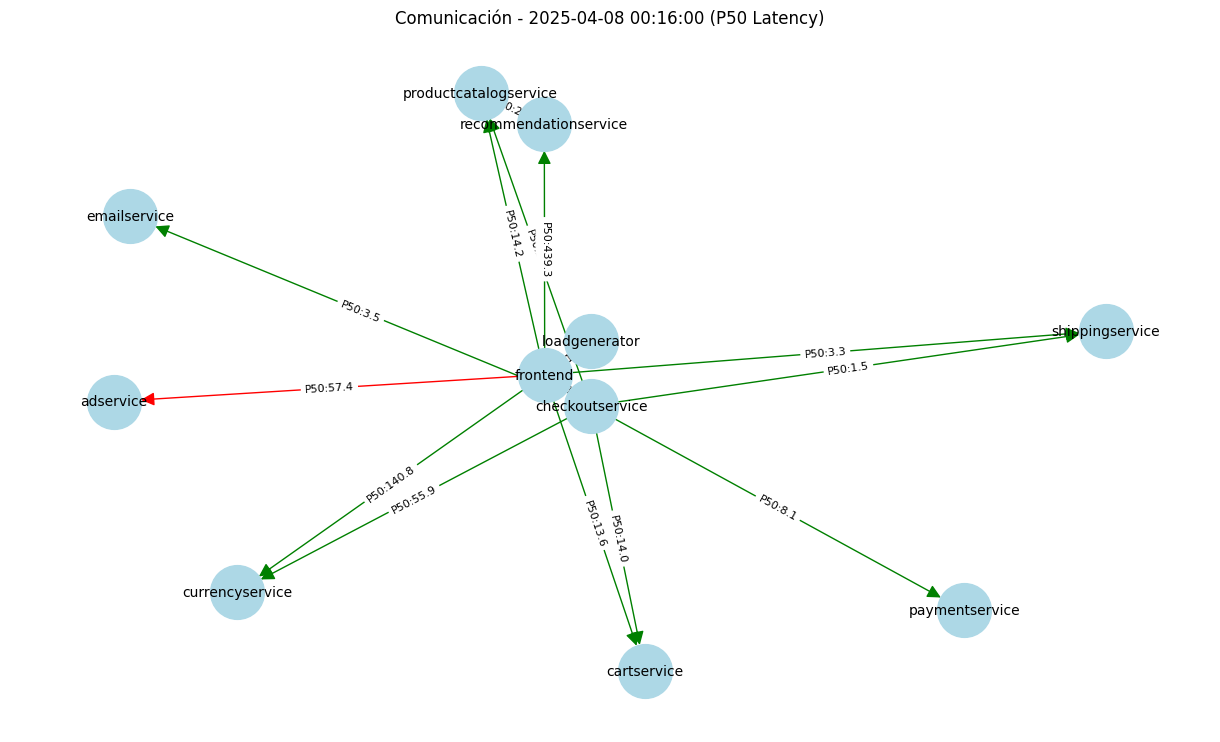

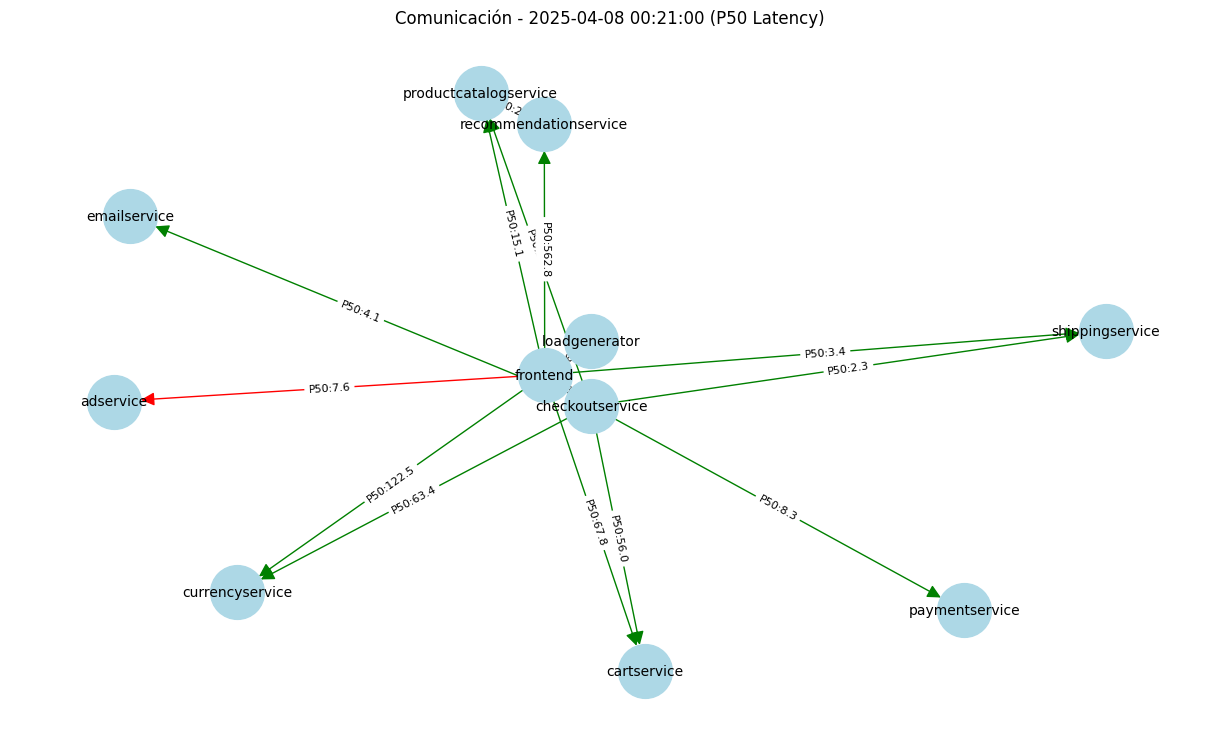

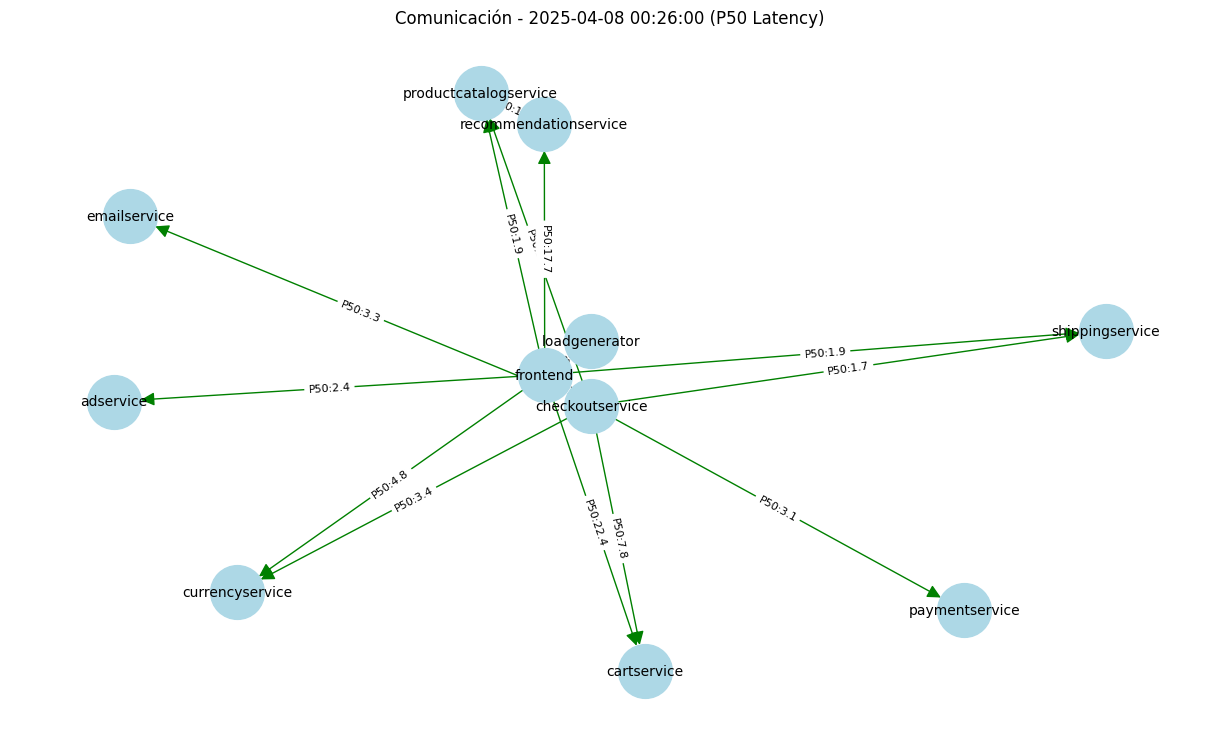

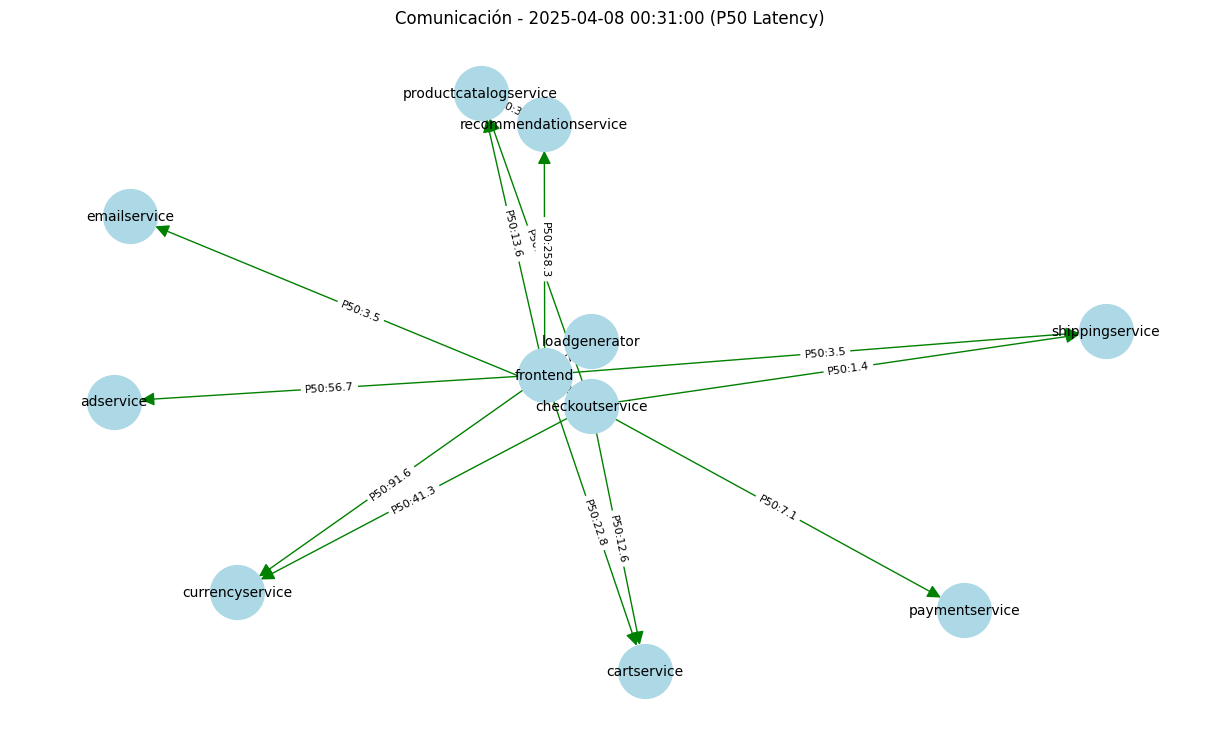

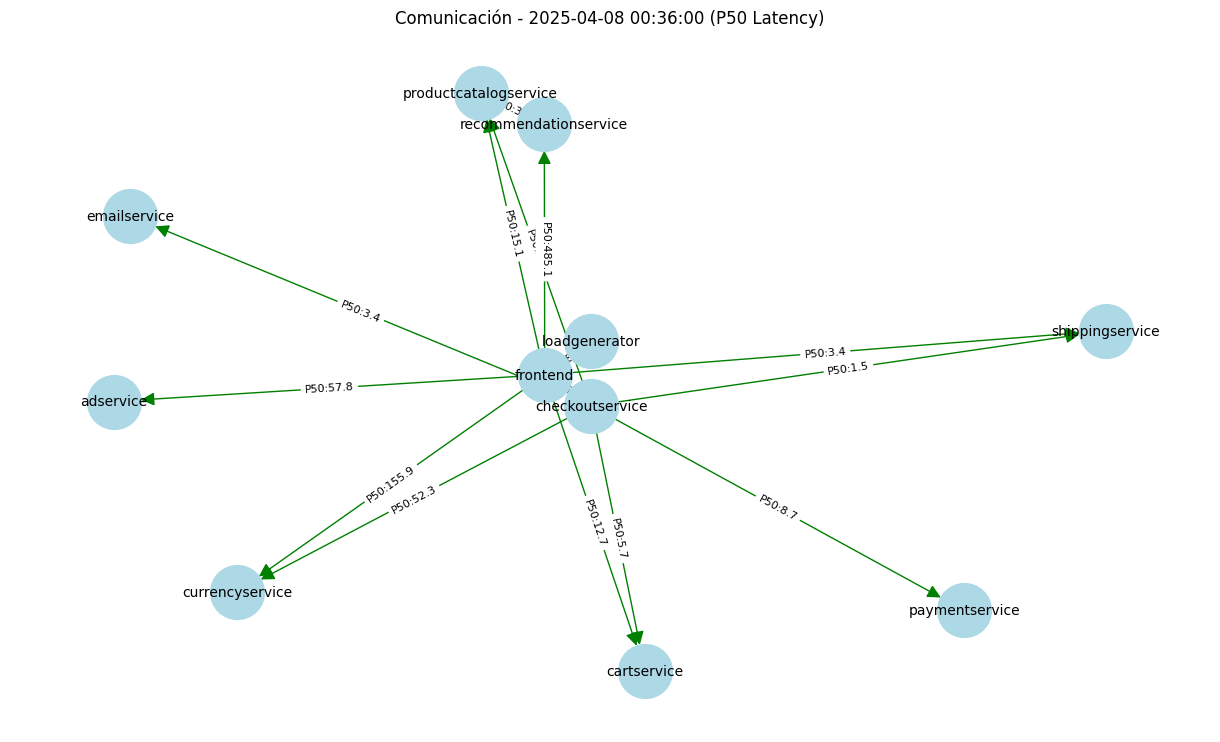

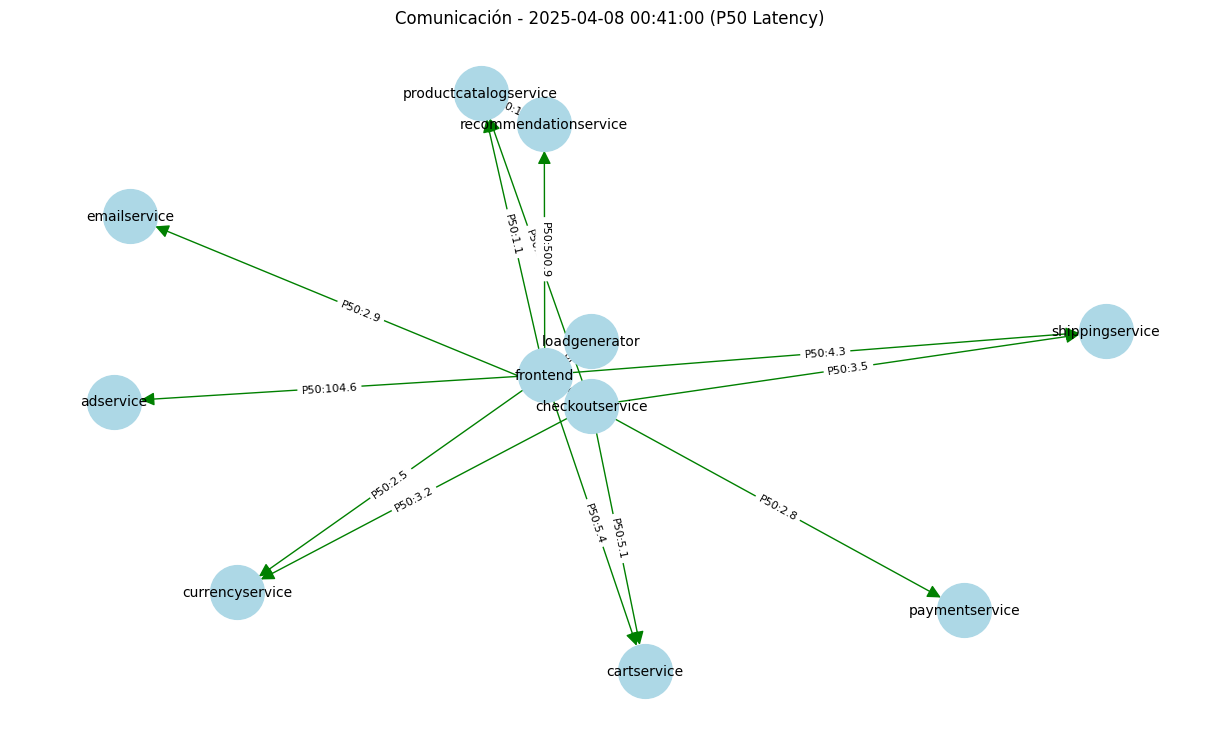

In [1]:
##P50 Latency Visualization


import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 📥 Cargar los datasets
df_kpi = pd.read_csv("kiali_kpi_metrics.csv")
df_pct = pd.read_csv("kiali_latency_percentiles.csv")

# 🔄 Preprocesamiento
df_kpi['time_window'] = df_kpi['time_window'].astype(str).str.strip()
df_kpi = df_kpi[df_kpi['time_window'] == "15S"].copy()
df_kpi['error_rate'] = pd.to_numeric(df_kpi['error_rate'], errors='coerce').fillna(0.0)
df_kpi = df_kpi[df_kpi['istio_request_bytes'] != 0.0]
df_kpi = df_kpi[df_kpi['new_request'] >= 0.0]
df_kpi = df_kpi.dropna(subset=["request_rate"])

# 🕒 Redondear timestamps al minuto
df_kpi['timestamp'] = pd.to_datetime(df_kpi['timestamp']).dt.floor('min')
df_pct['timestamp'] = pd.to_datetime(df_pct['timestamp']).dt.floor('min')

# 🧬 Unir datasets
df = pd.merge(
    df_kpi, df_pct,
    on=['source_workload', 'destination_workload', 'timestamp'],
    how='inner',
    suffixes=('_kpi', '_pct')
)

# 🎯 Asignar estado
def assign_status(er):
    return 0 if er < 0.15 else 1
df['status'] = df['error_rate_kpi'].apply(assign_status)

# 📆 Obtener momentos únicos
timestamps = sorted(df['timestamp'].dropna().unique())
step = 5

# 📊 Visualización temporal con métricas
for i in range(0, len(timestamps), step):
    ts = timestamps[i]
    snapshot = df[df['timestamp'] == ts]

    G = nx.DiGraph()
    nodes = set(snapshot['source_workload']).union(snapshot['destination_workload'])
    for node in nodes:
        G.add_node(node)

    for _, row in snapshot.iterrows():
        src = row["source_workload"]
        dst = row["destination_workload"]
        G.add_edge(src, dst,
                   status=row["status"],
                   p50=row.get("p50_latency", None),
                   p90=row.get("p90_latency", None),
                   p99=row.get("p99_latency", None))

    edge_colors = ['green' if G[u][v]['status'] == 0 else 'red' for u, v in G.edges()]
    edge_labels = { (u, v): f"P50:{G[u][v]['p50']:.1f}" for u, v in G.edges() if G[u][v]['p50'] is not None }

    plt.figure(figsize=(12, 7))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue', edge_color=edge_colors,
            node_size=1500, font_size=10, arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    plt.title(f"Comunicación - {ts.strftime('%Y-%m-%d %H:%M:%S')} (P50 Latency)")
    plt.show()


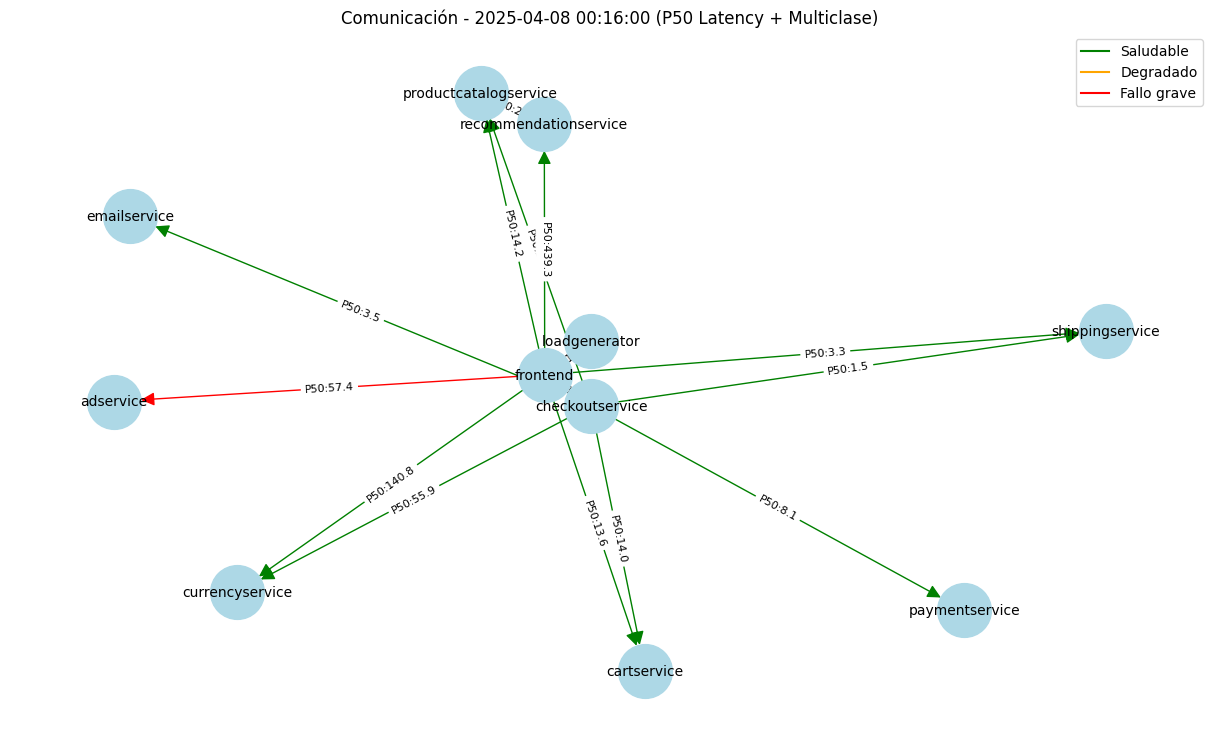

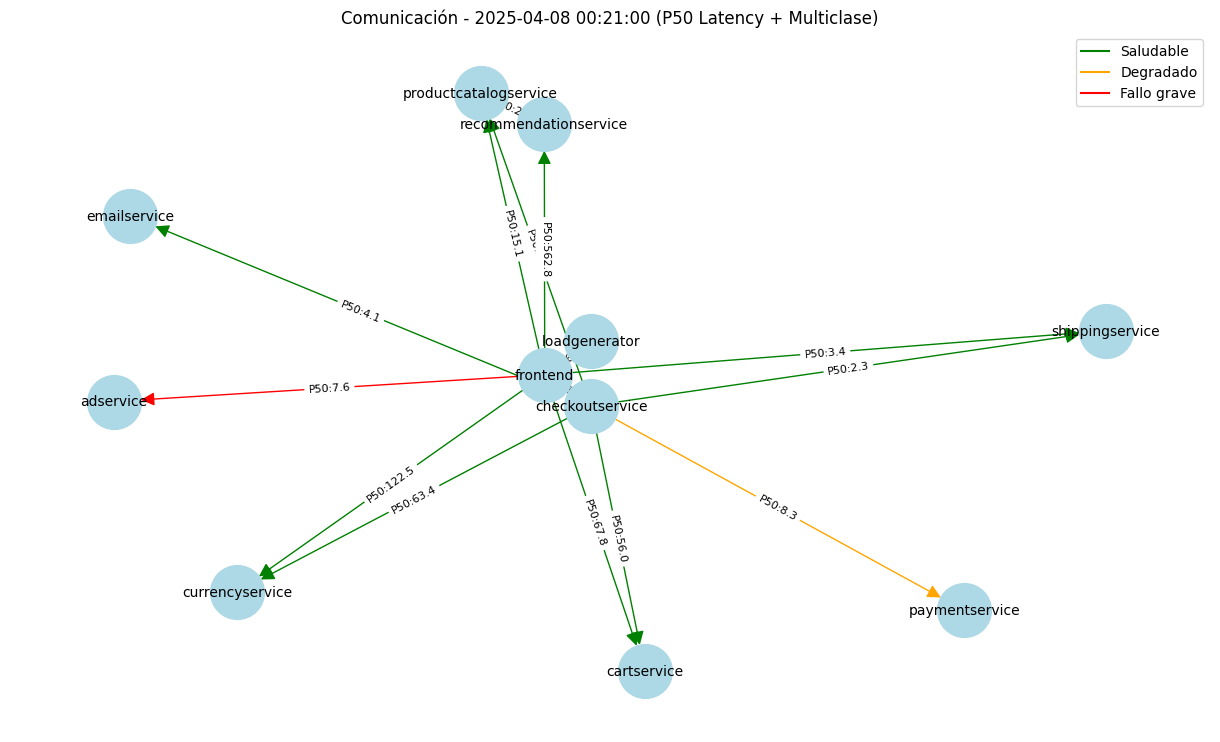

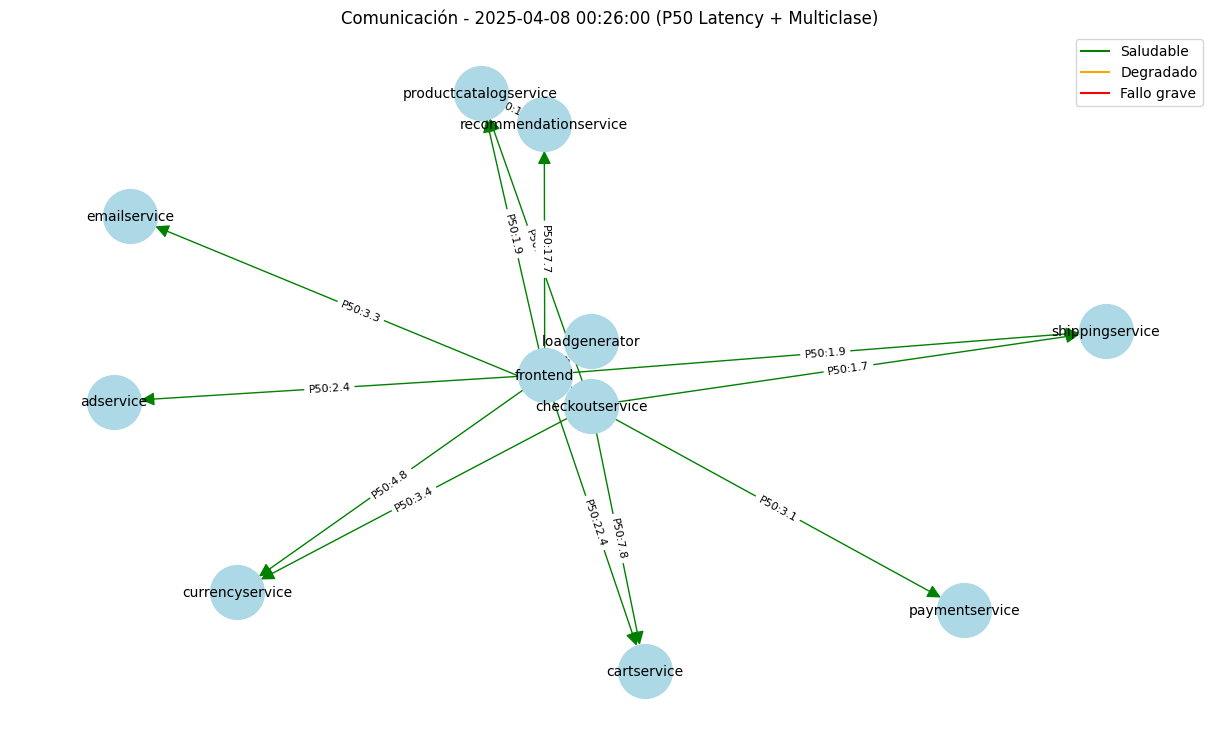

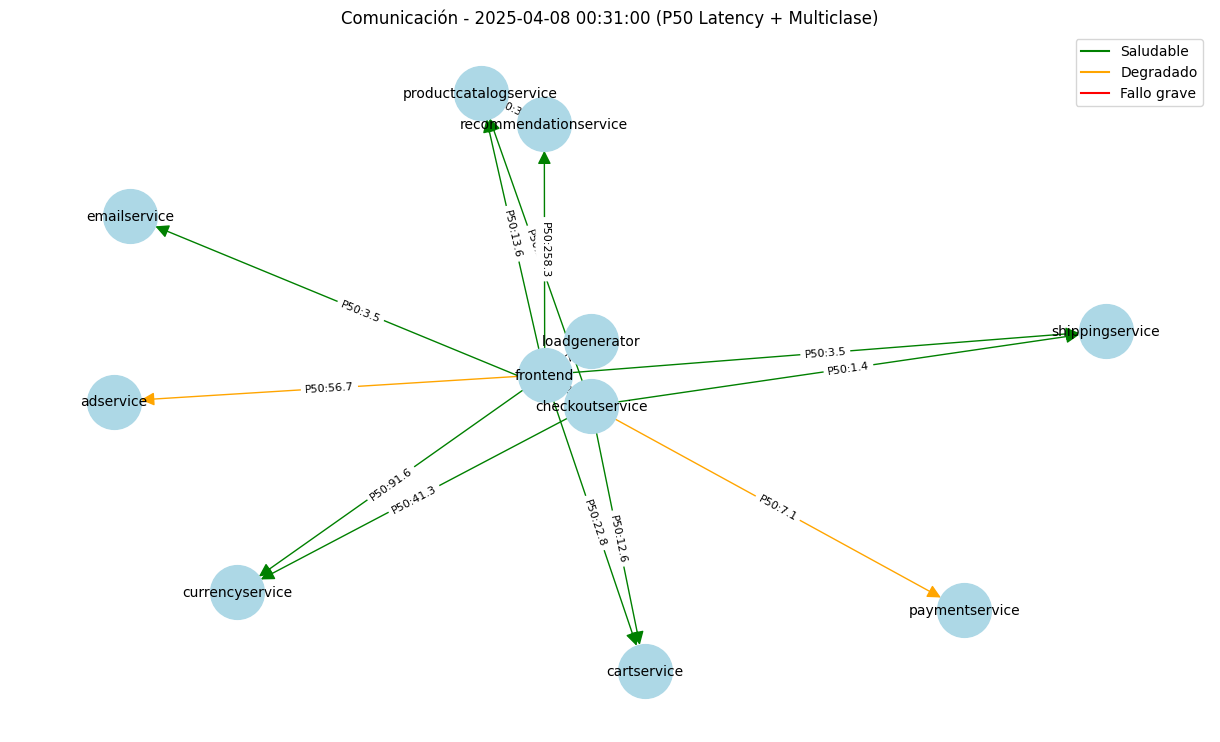

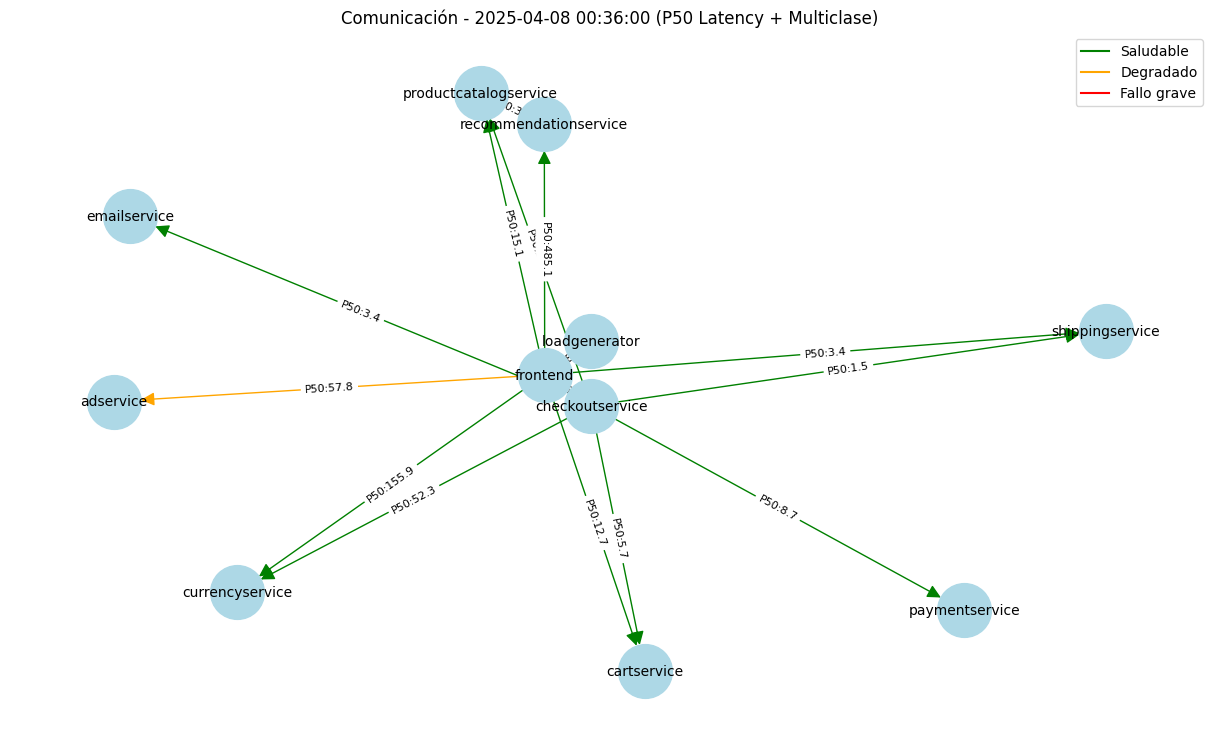

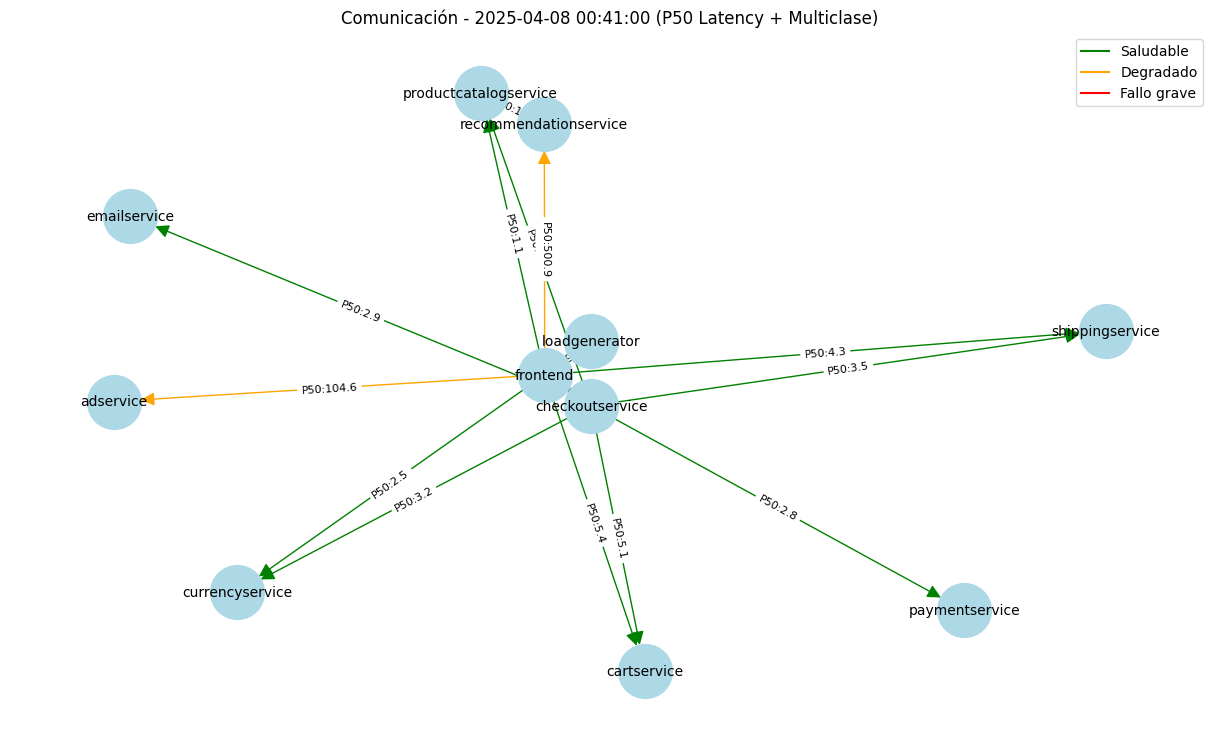

In [2]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 📥 Cargar datasets
df_kpi = pd.read_csv("kiali_kpi_metrics.csv")
df_pct = pd.read_csv("kiali_latency_percentiles.csv")

# 🔄 Preprocesamiento
df_kpi['time_window'] = df_kpi['time_window'].astype(str).str.strip()
df_kpi = df_kpi[df_kpi['time_window'] == "15S"].copy()
df_kpi['error_rate'] = pd.to_numeric(df_kpi['error_rate'], errors='coerce').fillna(0.0)
df_kpi = df_kpi[df_kpi['istio_request_bytes'] != 0.0]
df_kpi = df_kpi[df_kpi['new_request'] >= 0.0]
df_kpi = df_kpi.dropna(subset=["request_rate"])

# ⏱ Redondear timestamps al minuto
df_kpi['timestamp'] = pd.to_datetime(df_kpi['timestamp']).dt.floor('min')
df_pct['timestamp'] = pd.to_datetime(df_pct['timestamp']).dt.floor('min')

# 🧬 Merge datasets
df = pd.merge(
    df_kpi, df_pct,
    on=['source_workload', 'destination_workload', 'timestamp'],
    how='inner',
    suffixes=('_kpi', '_pct')
)

# 🏷 Clasificación multiclase
def assign_status_multiclase(er):
    if er < 0.01:
        return 0  # Saludable
    elif er < 0.15:
        return 1  # Degradado
    else:
        return 2  # Fallo grave

df['status'] = df['error_rate_kpi'].apply(assign_status_multiclase)

# 📆 Momentos únicos
timestamps = sorted(df['timestamp'].dropna().unique())
step = 5

# 🎨 Mapeo de colores por clase
color_map = {0: 'green', 1: 'orange', 2: 'red'}
label_map = {0: "Saludable", 1: "Degradado", 2: "Fallo grave"}

# 📊 Visualización temporal
for i in range(0, len(timestamps), step):
    ts = timestamps[i]
    snapshot = df[df['timestamp'] == ts]

    G = nx.DiGraph()
    nodes = set(snapshot['source_workload']).union(snapshot['destination_workload'])
    for node in nodes:
        G.add_node(node)

    for _, row in snapshot.iterrows():
        src = row["source_workload"]
        dst = row["destination_workload"]
        G.add_edge(src, dst,
                   status=row["status"],
                   p50=row.get("p50_latency", None))

    edge_colors = [color_map.get(G[u][v]['status'], 'gray') for u, v in G.edges()]
    edge_labels = { (u, v): f"P50:{G[u][v]['p50']:.1f}" for u, v in G.edges() if G[u][v]['p50'] is not None }

    plt.figure(figsize=(12, 7))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            edge_color=edge_colors, node_size=1500, font_size=10, arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    # Añadir leyenda personalizada
    for cls, color in color_map.items():
        plt.plot([], [], color=color, label=label_map[cls])
    plt.legend(loc="upper right")

    plt.title(f"Comunicación - {ts.strftime('%Y-%m-%d %H:%M:%S')} (P50 Latency + Multiclase)")
    plt.show()


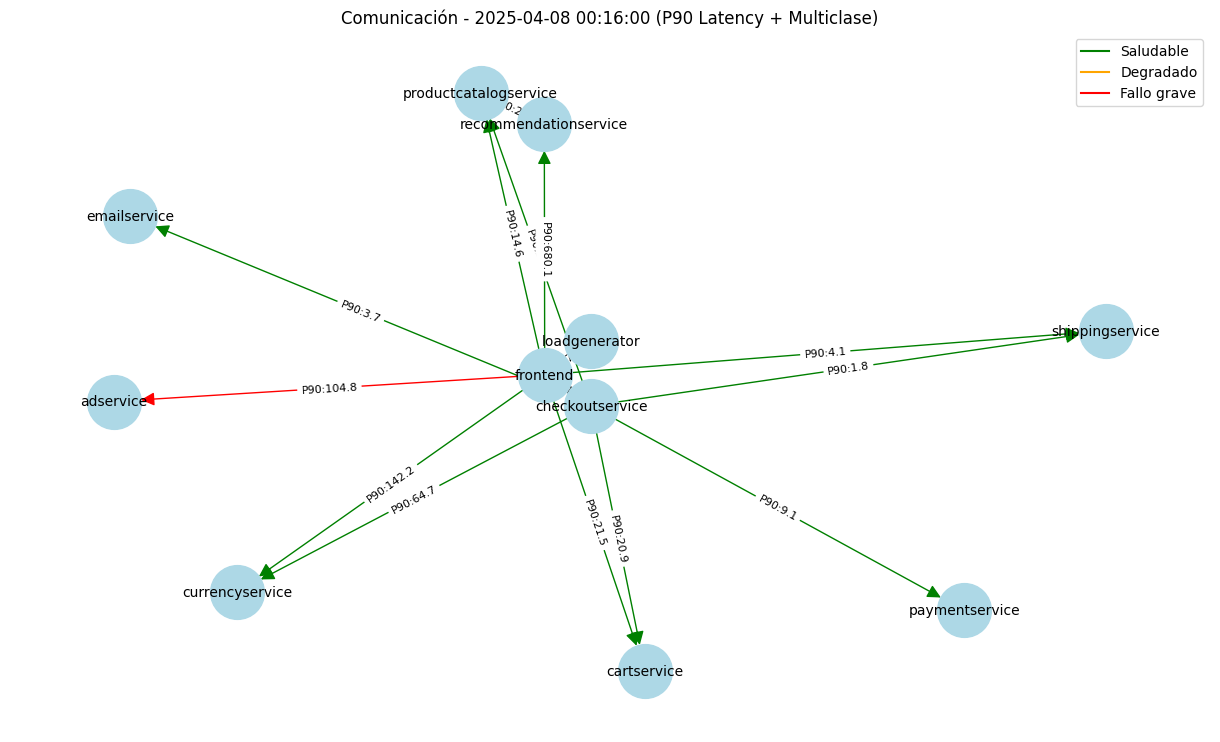

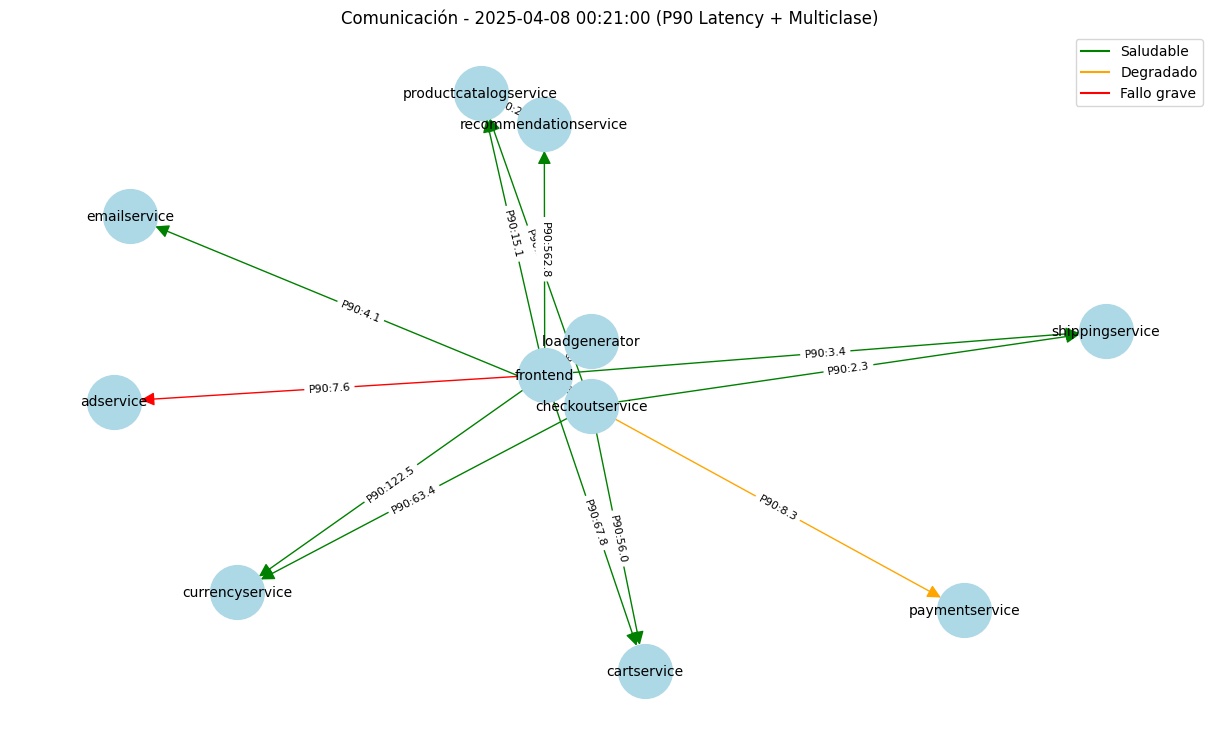

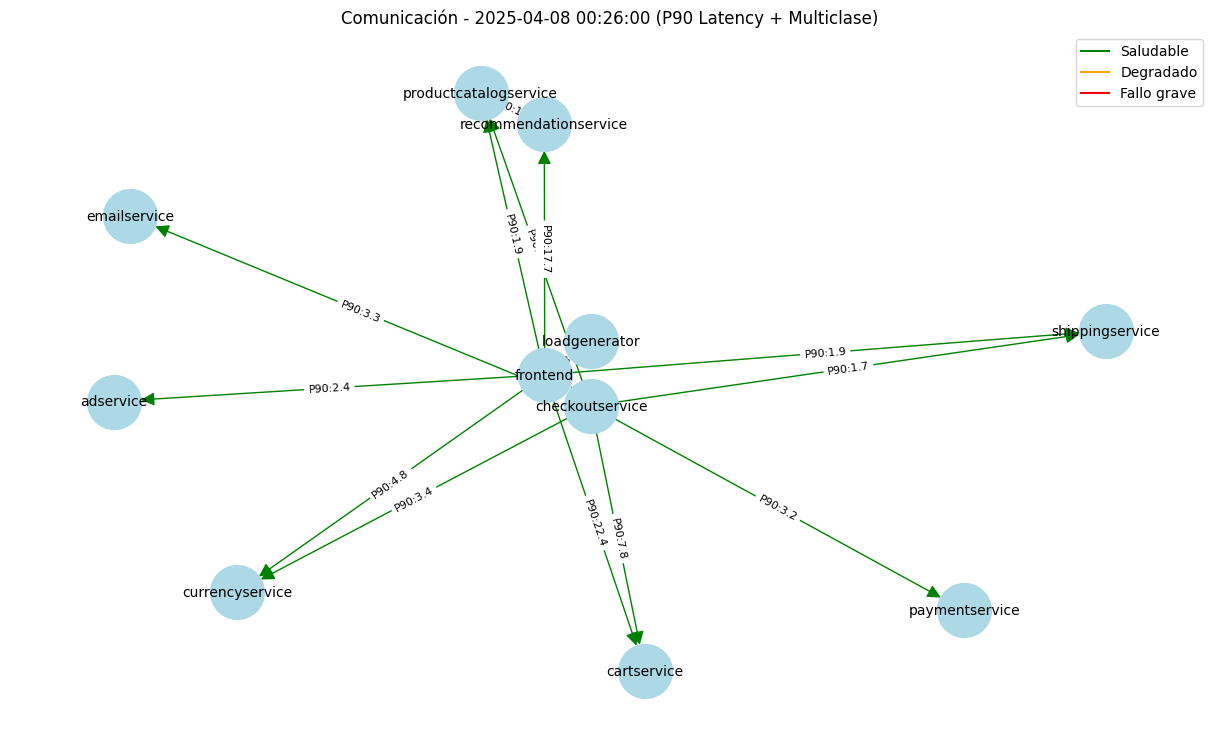

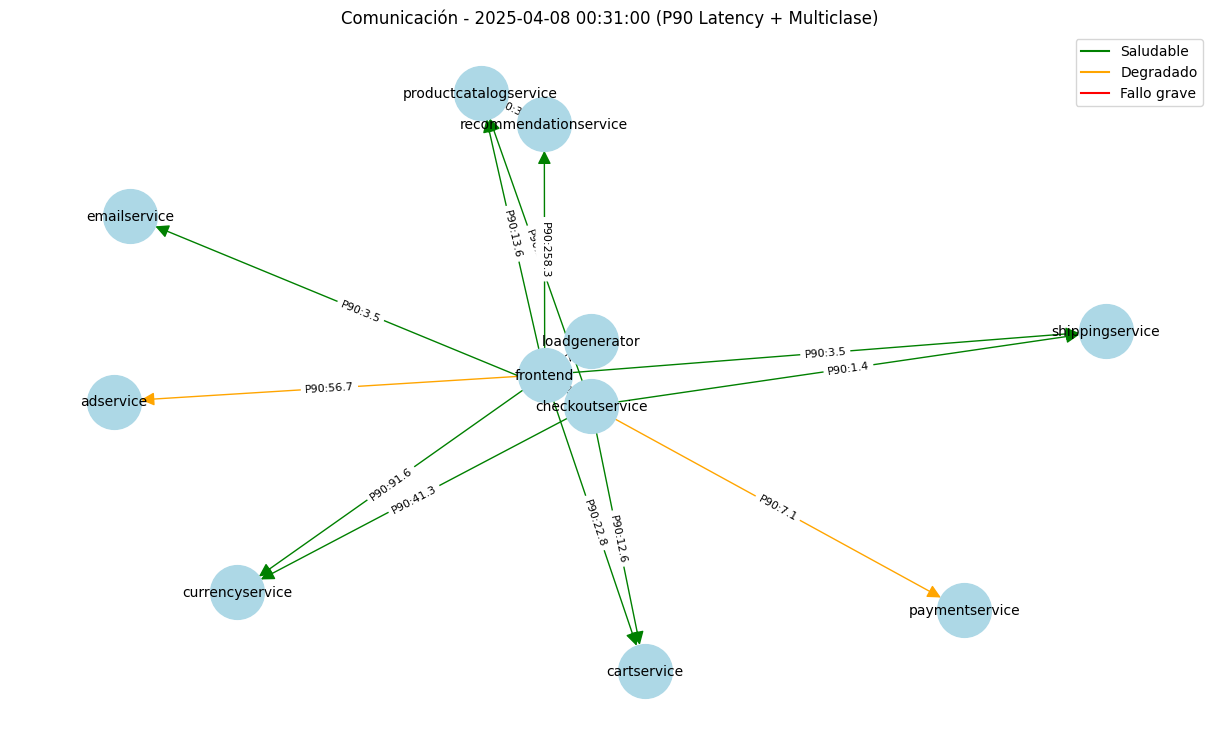

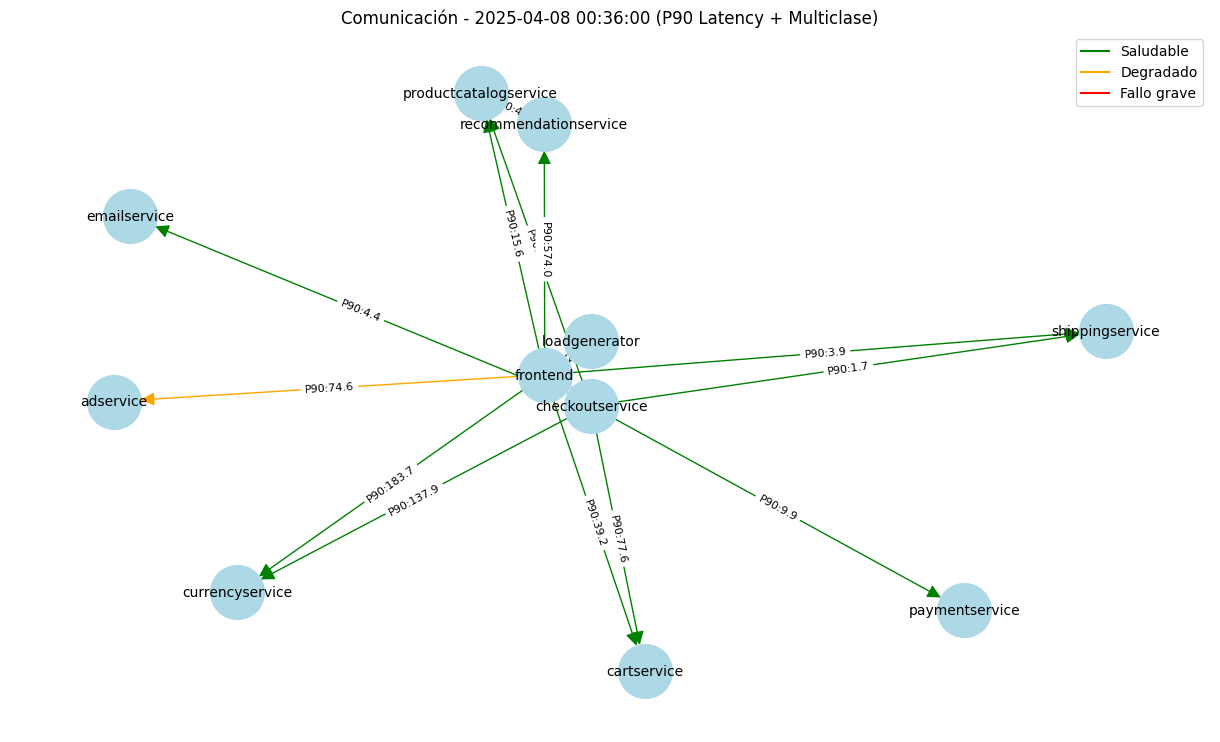

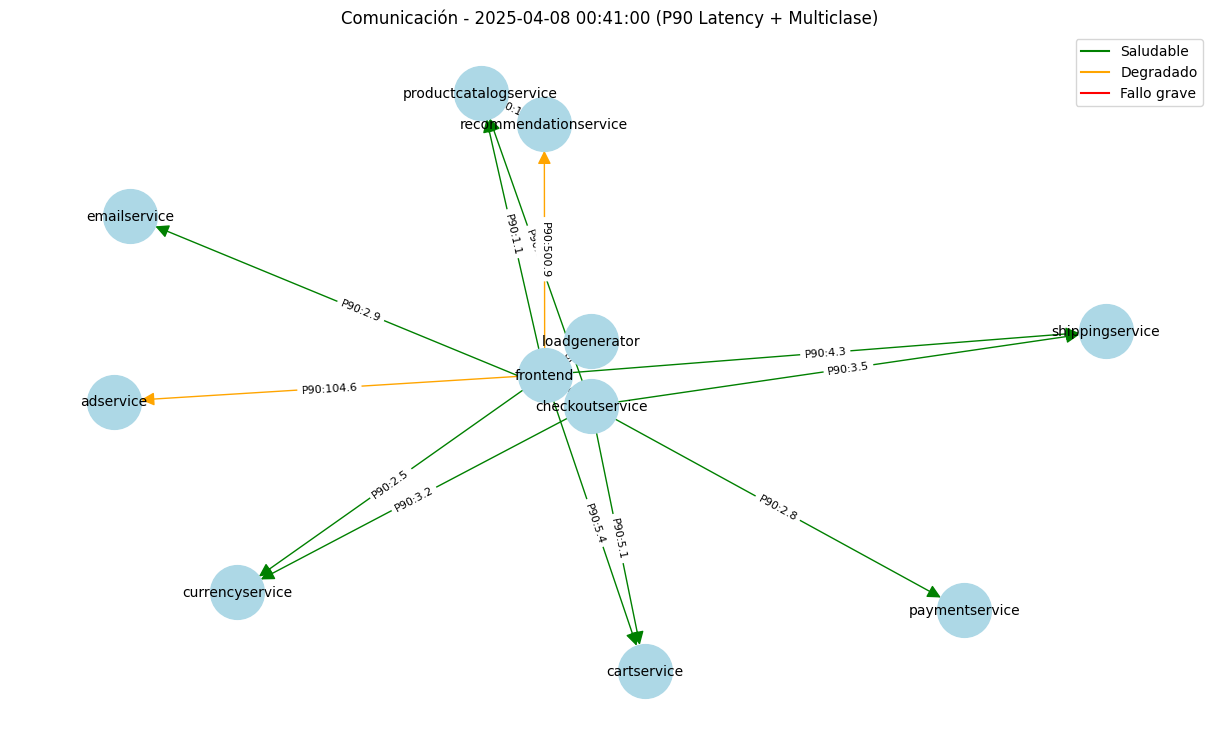

In [3]:
## p90 Latency Visualization
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 📥 Cargar datasets
df_kpi = pd.read_csv("kiali_kpi_metrics.csv")
df_pct = pd.read_csv("kiali_latency_percentiles.csv")

# 🔄 Preprocesamiento
df_kpi['time_window'] = df_kpi['time_window'].astype(str).str.strip()
df_kpi = df_kpi[df_kpi['time_window'] == "15S"].copy()
df_kpi['error_rate'] = pd.to_numeric(df_kpi['error_rate'], errors='coerce').fillna(0.0)
df_kpi = df_kpi[df_kpi['istio_request_bytes'] != 0.0]
df_kpi = df_kpi[df_kpi['new_request'] >= 0.0]
df_kpi = df_kpi.dropna(subset=["request_rate"])

# ⏱ Redondear timestamps al minuto
df_kpi['timestamp'] = pd.to_datetime(df_kpi['timestamp']).dt.floor('min')
df_pct['timestamp'] = pd.to_datetime(df_pct['timestamp']).dt.floor('min')

# 🧬 Merge
df = pd.merge(
    df_kpi, df_pct,
    on=['source_workload', 'destination_workload', 'timestamp'],
    how='inner',
    suffixes=('_kpi', '_pct')
)

# 🏷 Etiquetado multiclase
def assign_status_multiclase(er):
    if er < 0.01:
        return 0  # Saludable
    elif er < 0.15:
        return 1  # Degradado
    else:
        return 2  # Fallo grave

df['status'] = df['error_rate_kpi'].apply(assign_status_multiclase)

# ✅ CAMBIA AQUÍ para mostrar P50, P90 o P99
percentil = "p90_latency"  # ← Cambia a "p50_latency" o "p99_latency" si lo deseas
label_tag = percentil.upper().replace("_LATENCY", "")

# 📆 Momentos únicos
timestamps = sorted(df['timestamp'].dropna().unique())
step = 5

# Colores para las clases
color_map = {0: 'green', 1: 'orange', 2: 'red'}
label_map = {0: "Saludable", 1: "Degradado", 2: "Fallo grave"}

# Visualización temporal
for i in range(0, len(timestamps), step):
    ts = timestamps[i]
    snapshot = df[df['timestamp'] == ts]

    G = nx.DiGraph()
    nodes = set(snapshot['source_workload']).union(snapshot['destination_workload'])
    for node in nodes:
        G.add_node(node)

    for _, row in snapshot.iterrows():
        src = row["source_workload"]
        dst = row["destination_workload"]
        G.add_edge(src, dst,
                   status=row["status"],
                   latency=row.get(percentil, None))

    edge_colors = [color_map.get(G[u][v]['status'], 'gray') for u, v in G.edges()]
    edge_labels = {
        (u, v): f"{label_tag}:{G[u][v]['latency']:.1f}"
        for u, v in G.edges() if G[u][v]['latency'] is not None
    }

    plt.figure(figsize=(12, 7))
    pos = nx.spring_layout(G, seed=42)
    nx.draw(G, pos, with_labels=True, node_color='lightblue',
            edge_color=edge_colors, node_size=1500, font_size=10, arrowsize=20)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

    for cls, color in color_map.items():
        plt.plot([], [], color=color, label=label_map[cls])
    plt.legend(loc="upper right")

    plt.title(f"Comunicación - {ts.strftime('%Y-%m-%d %H:%M:%S')} ({label_tag} Latency + Multiclase)")
    plt.show()


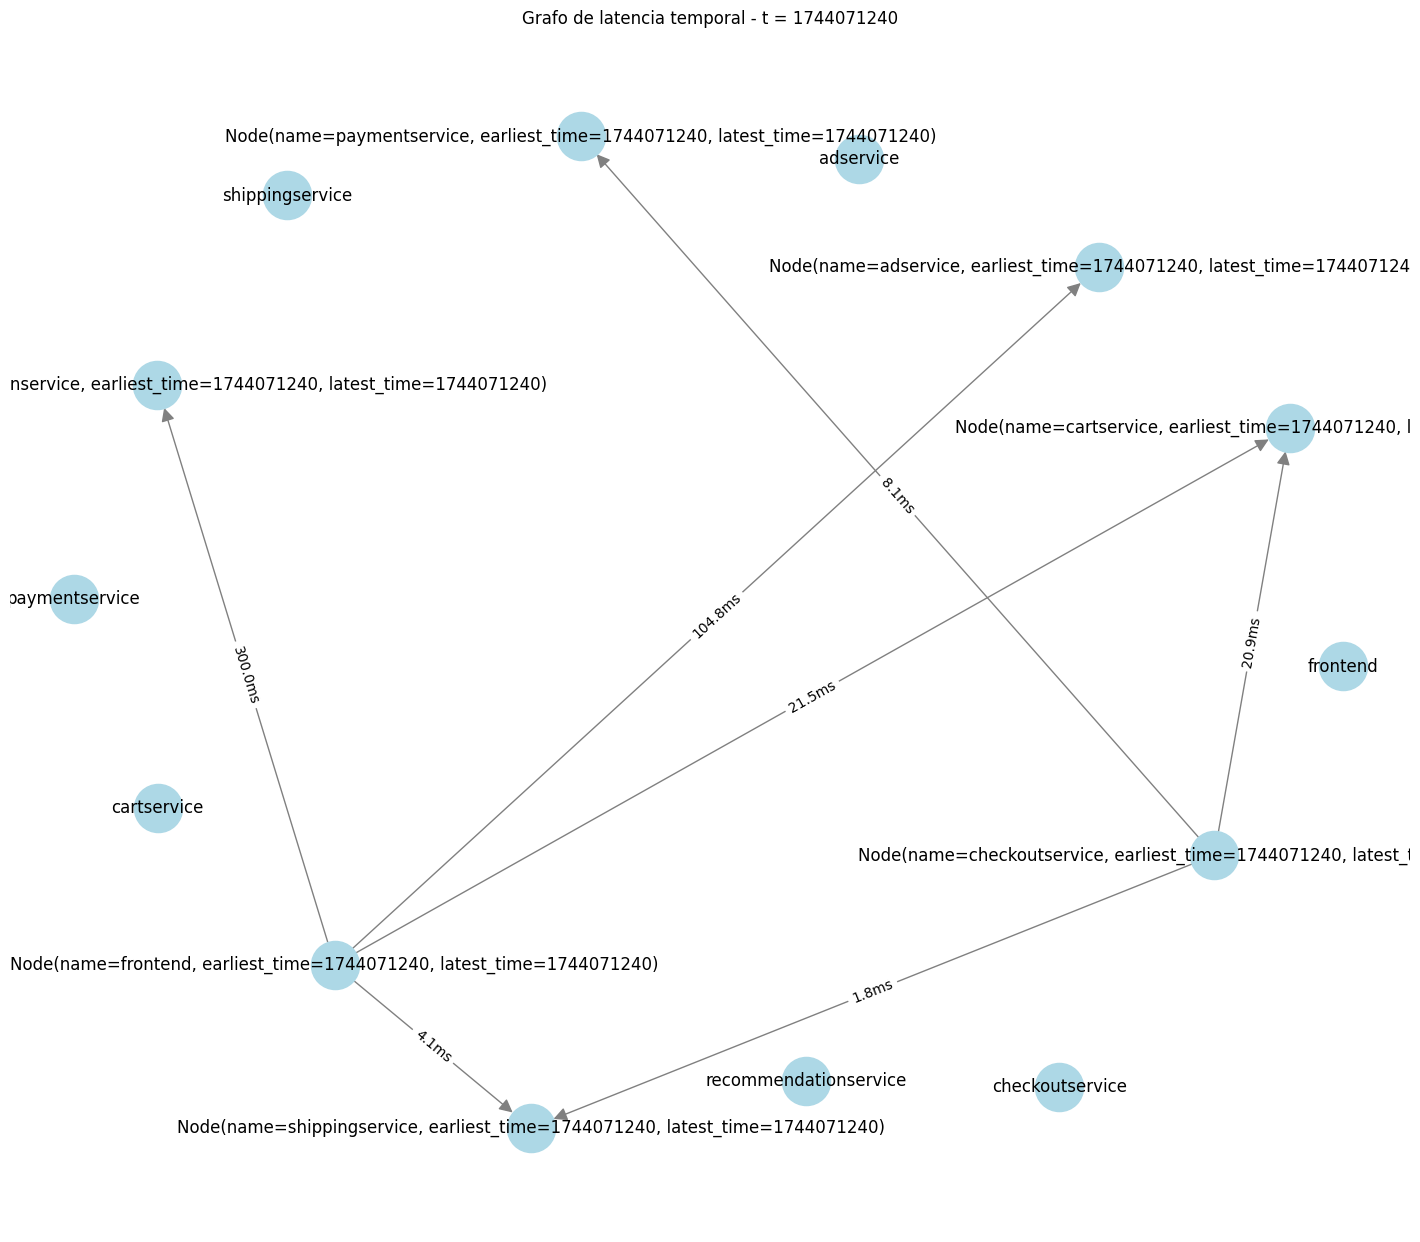

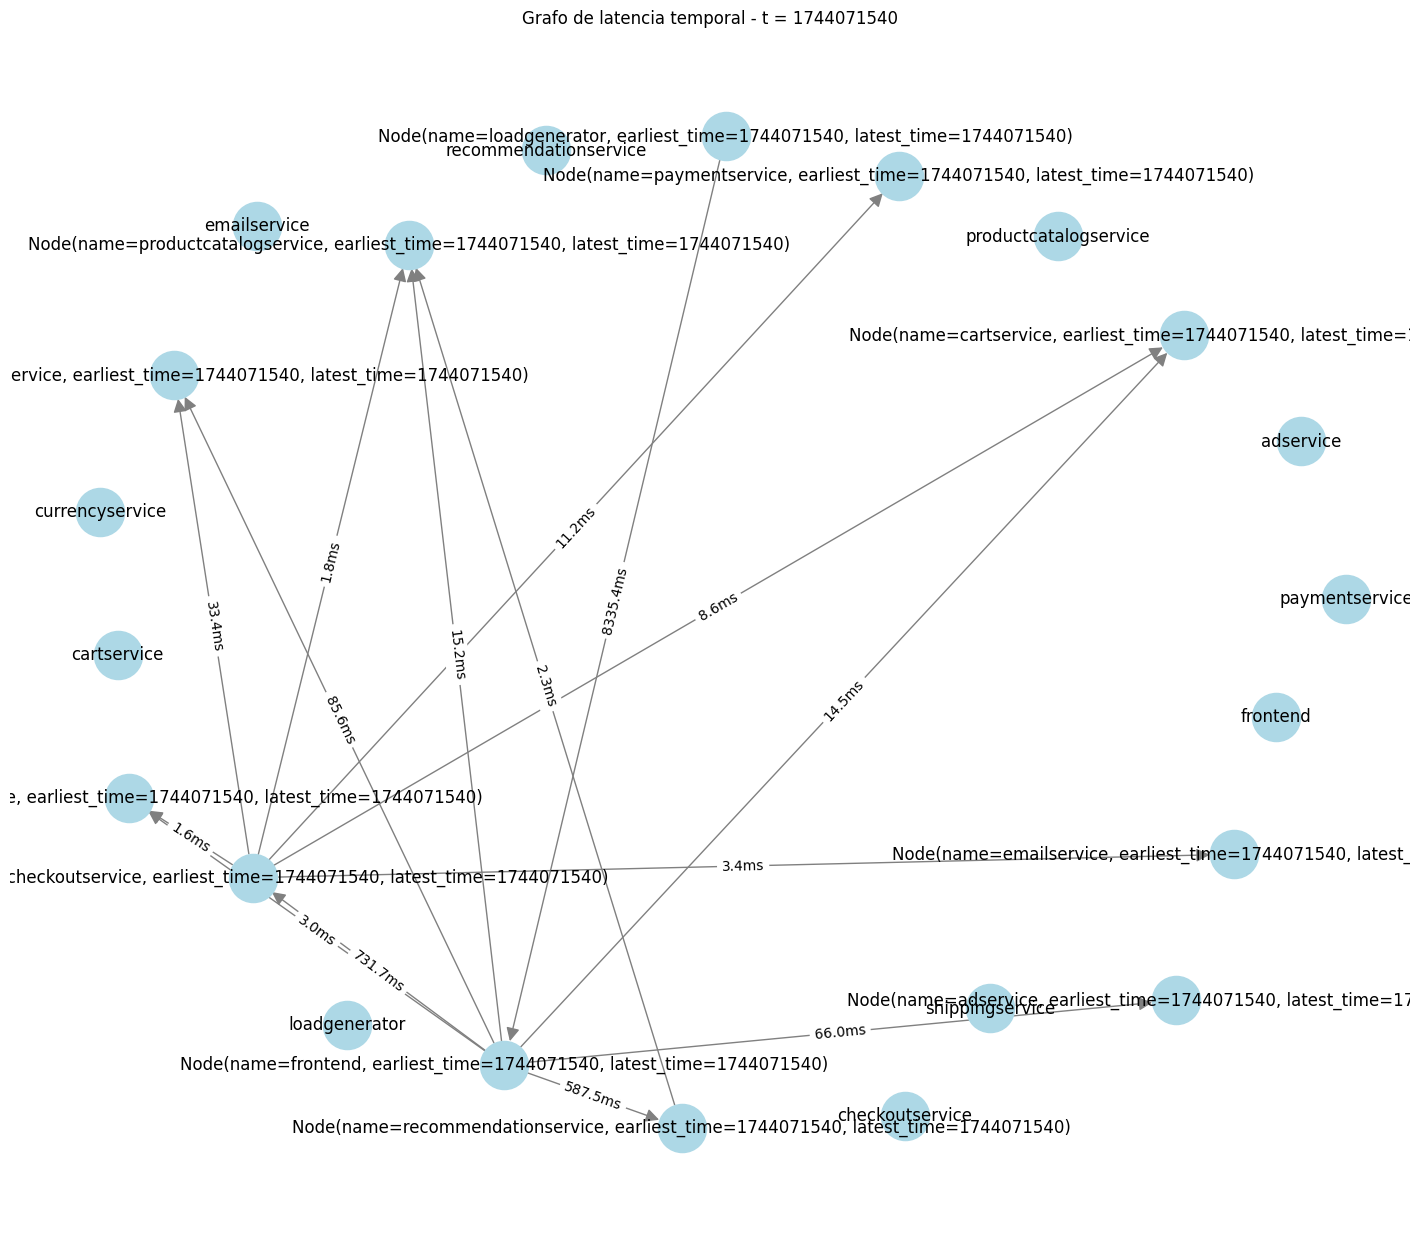

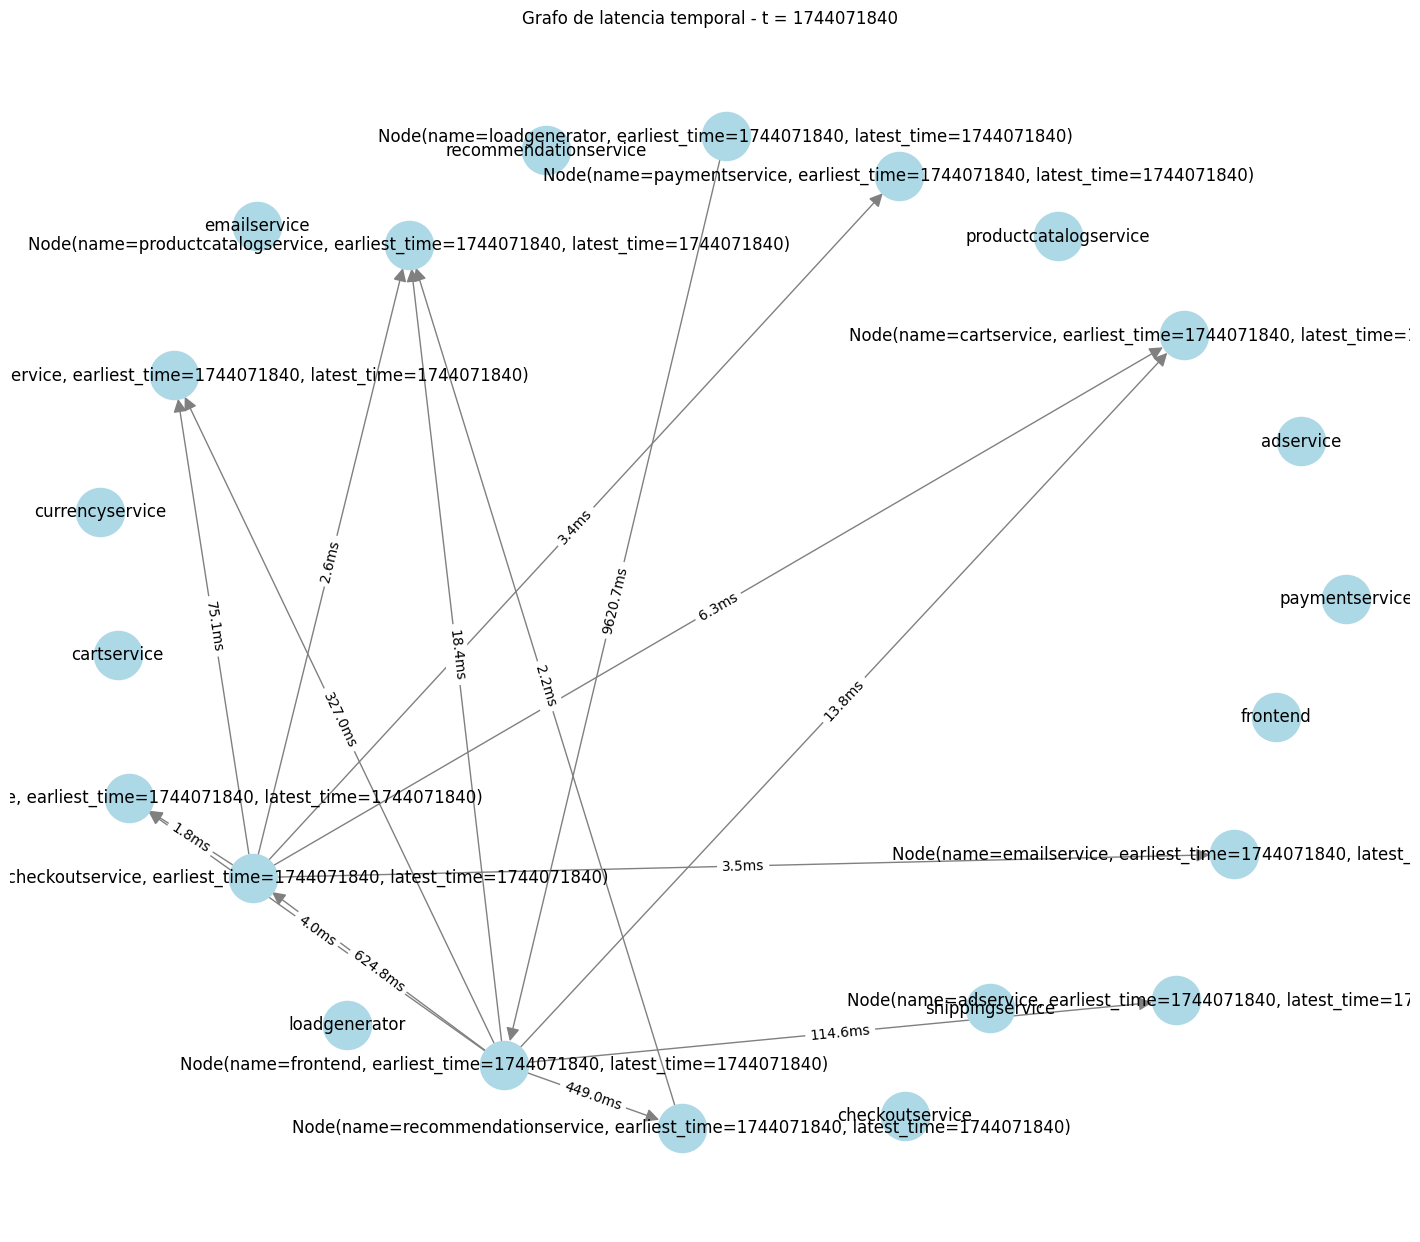

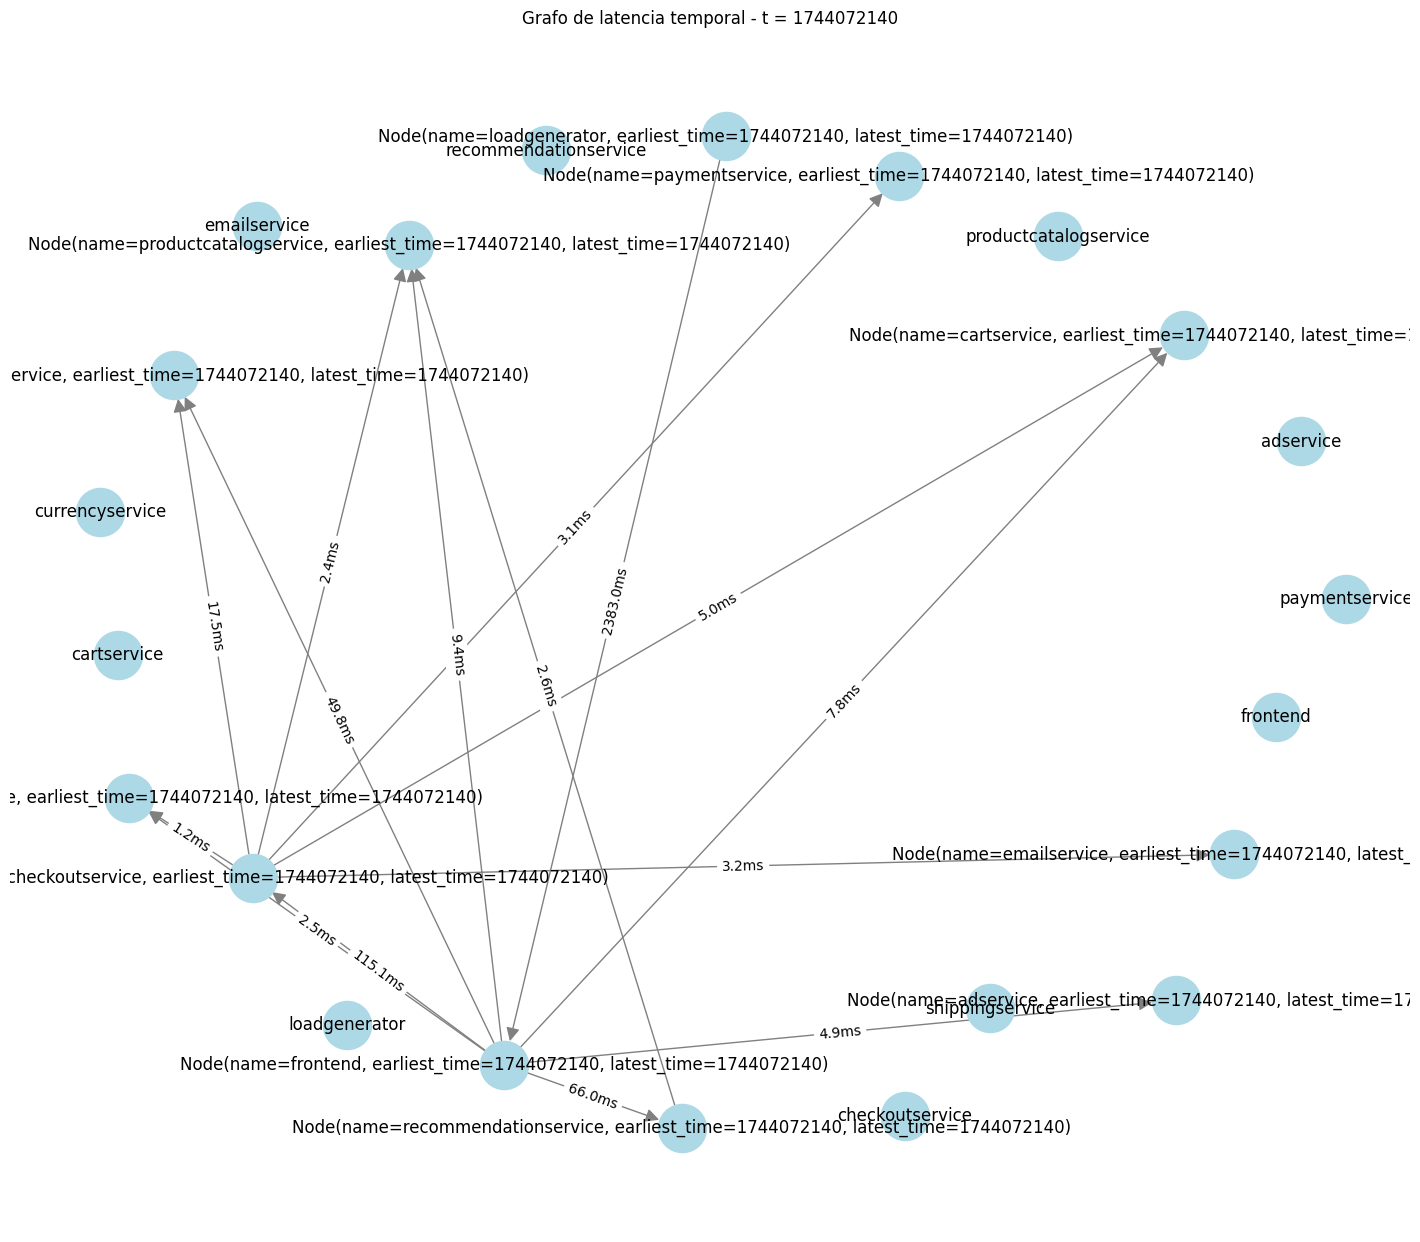

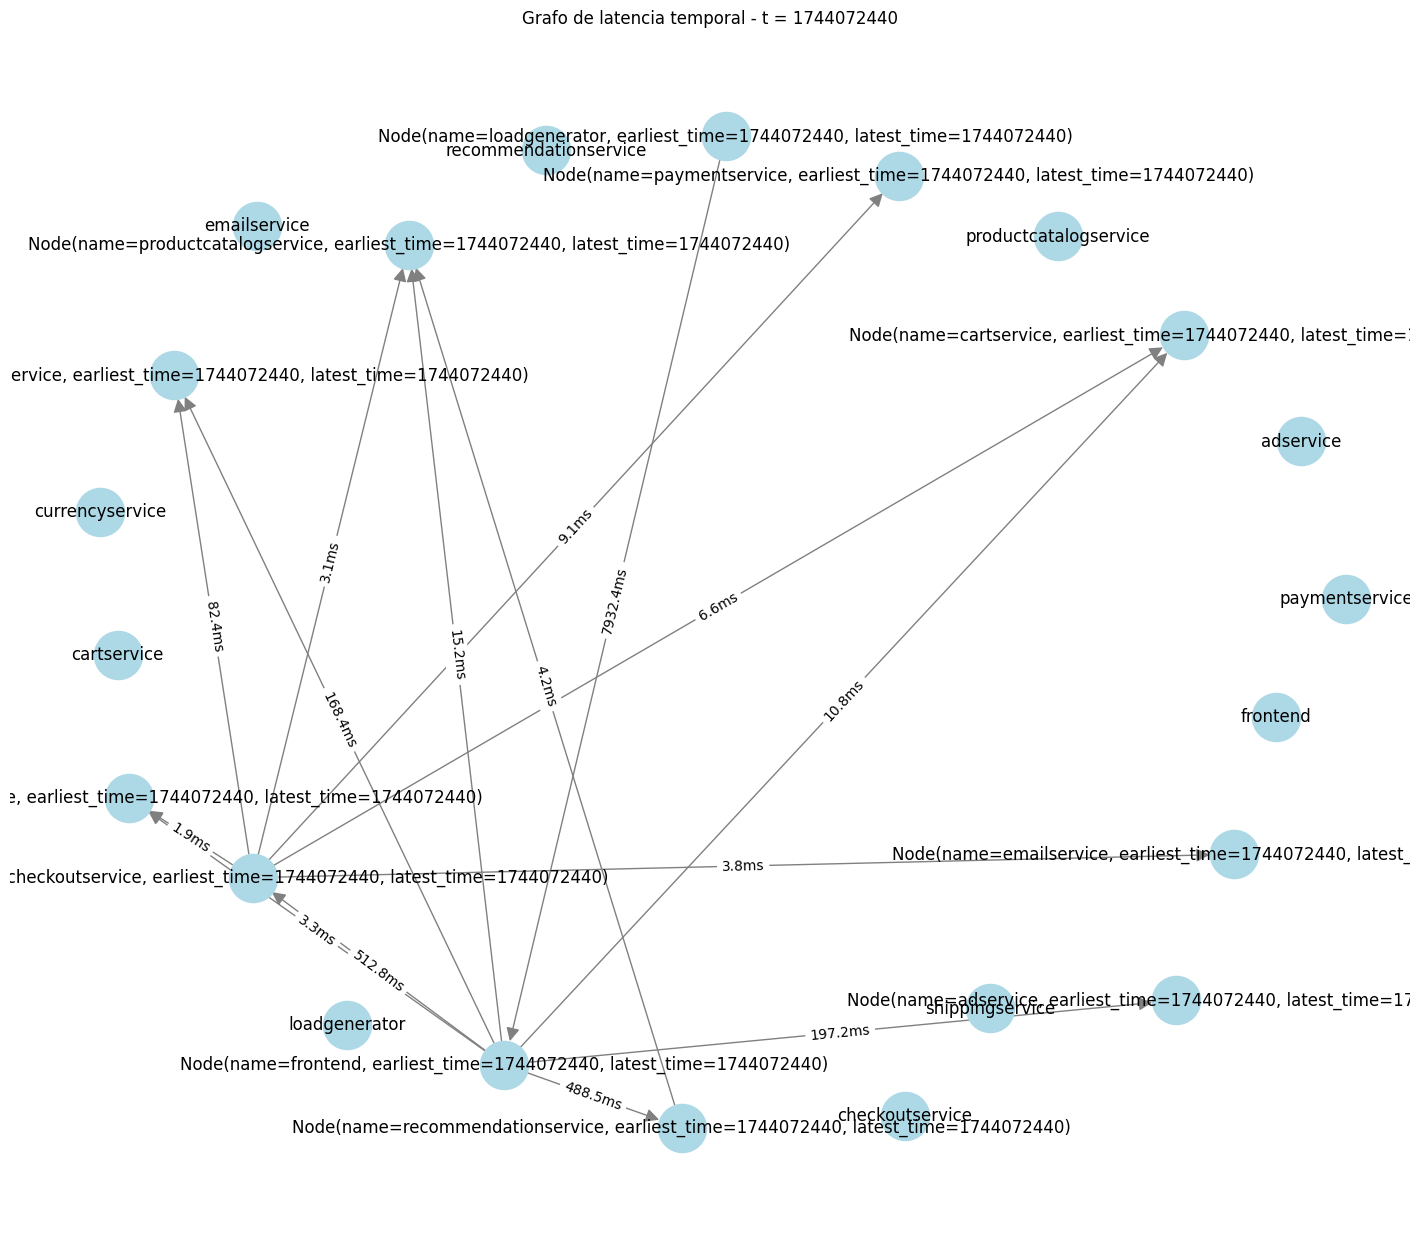

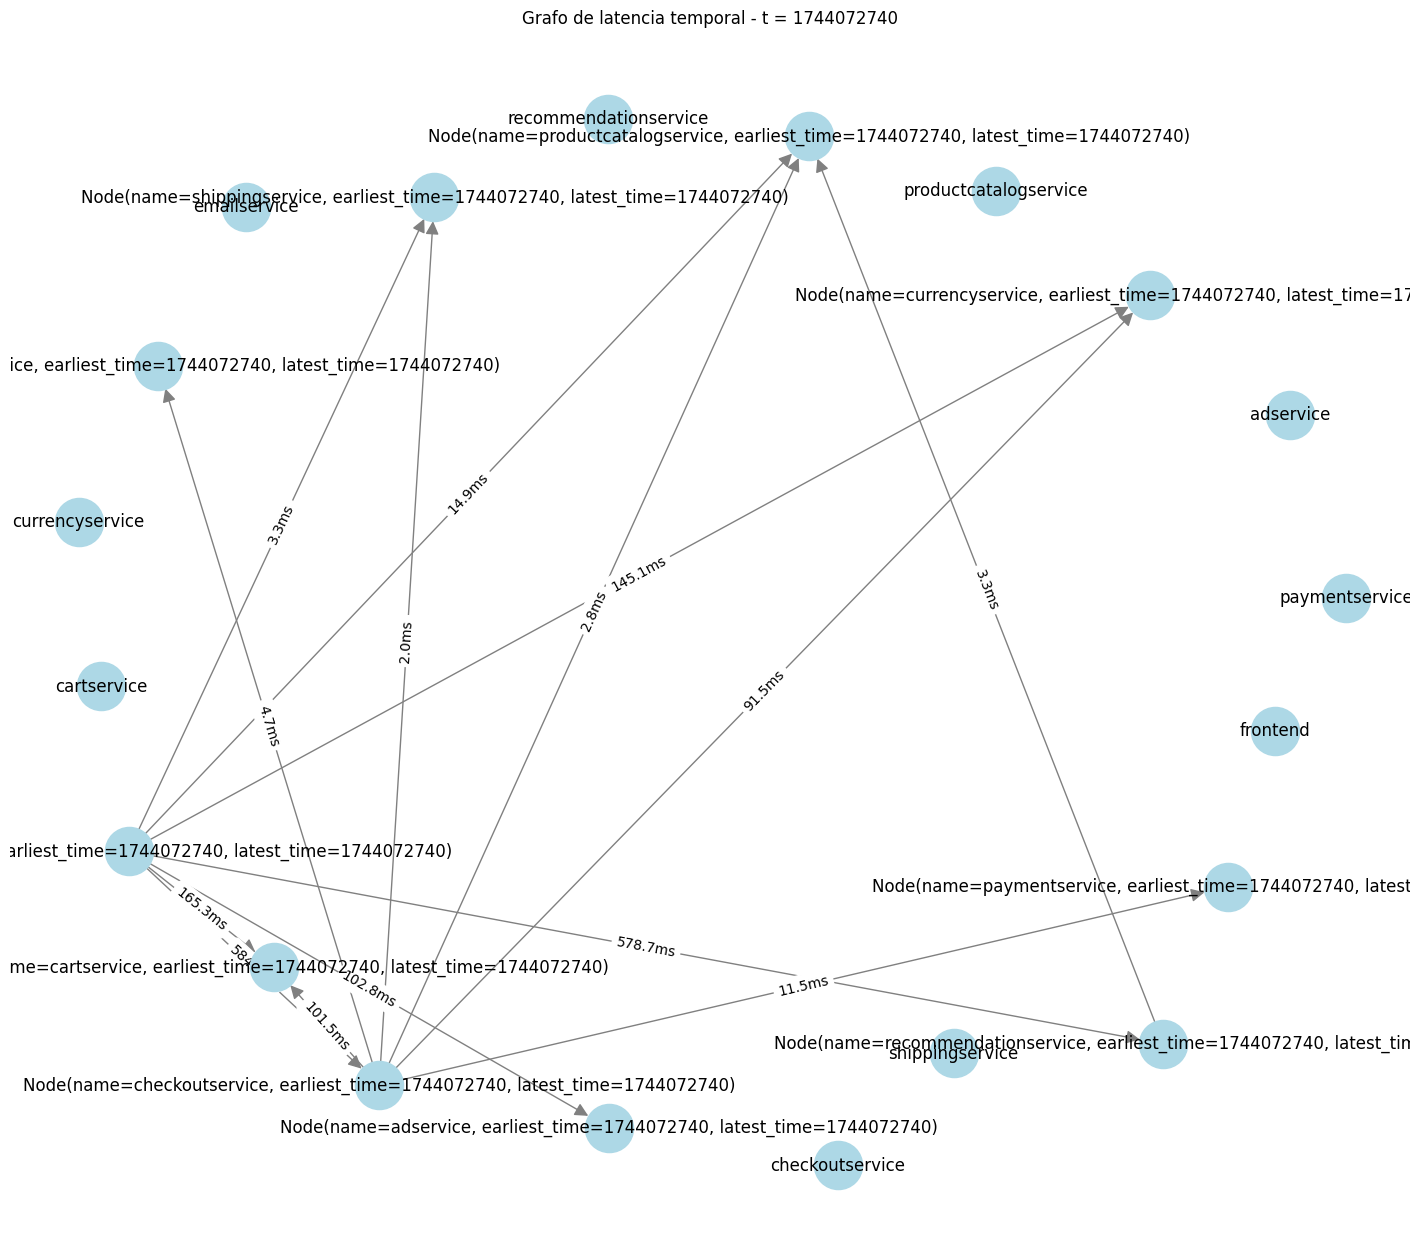

In [4]:
from raphtory import Graph
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

# 1. Cargar tus datos de latencia temporal
df = pd.read_csv("kiali_latency_percentiles.csv")  # o el archivo que uses
df['timestamp'] = pd.to_datetime(df['timestamp']).astype(int) // 10**9

# 2. Crear grafo en Raphtory
g = Graph()
for _, row in df.iterrows():
    g.add_node(timestamp=1, id=str(row['source_workload']))
    g.add_node(timestamp=1, id=str(row['destination_workload']))
    g.add_edge(
        timestamp=int(row['timestamp']),
        src=str(row['source_workload']),
        dst=str(row['destination_workload']),
        properties={
            "latency": row["p95_latency"],
            "p90": row["p90_latency"],
            "p50": row["p50_latency"]
        }
    )

# 3. Visualizar evolución temporal
for ts in sorted(df['timestamp'].unique())[::5]:
    snapshot = g.at(ts)
    G_nx = nx.DiGraph()

    for node in snapshot.nodes:
        G_nx.add_node(str(node.name))

    for edge in snapshot.edges:
        latency = edge.properties["latency"]
        G_nx.add_edge(edge.src, edge.dst, latency=latency)

    edge_labels = {(u, v): f"{G_nx[u][v]['latency']:.1f}ms" for u, v in G_nx.edges()}

    plt.figure(figsize=(14,12))
    pos = nx.spring_layout(G_nx, seed=52, k=3)
    nx.draw(G_nx, pos, with_labels=True, node_color='lightblue',
            edge_color='gray', node_size=1200, arrowsize=20)
    nx.draw_networkx_edge_labels(G_nx, pos, edge_labels=edge_labels, font_size=10)
    plt.title(f"Grafo de latencia temporal - t = {ts}")
    plt.show()


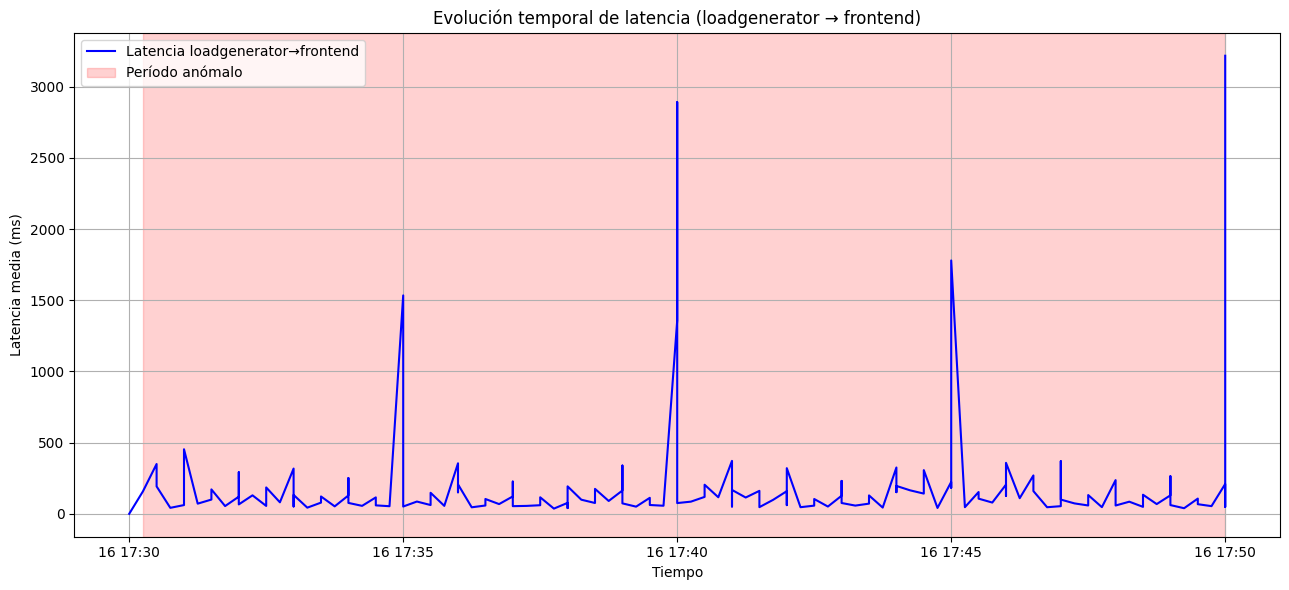

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset de comunicación
df = pd.read_csv("kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])

# Opción 1: Selecciona automáticamente la relación con más anomalías
anom_df = df[df["Abnormality class"] != "Normal"]
if not anom_df.empty:
    rel = anom_df.groupby(["source_workload", "destination_workload"]).size().idxmax()
    src, dst = rel
else:
    # Si no hay anomalías, selecciona la relación con más tráfico
    rel = df.groupby(["source_workload", "destination_workload"])["average_latency"].mean().idxmax()
    src, dst = rel

df_rel = df[(df["source_workload"] == src) & (df["destination_workload"] == dst)].sort_values("timestamp")

plt.figure(figsize=(13, 6))
plt.plot(df_rel["timestamp"], df_rel["average_latency"], label=f"Latencia {src}→{dst}", color="blue")

# Sombrear períodos anómalos
anom_mask = df_rel["Abnormality class"] != "Normal"
if anom_mask.any():
    plt.axvspan(
        df_rel[anom_mask]["timestamp"].min(),
        df_rel[anom_mask]["timestamp"].max(),
        color="red", alpha=0.18, label="Período anómalo"
    )

plt.title(f"Evolución temporal de latencia ({src} → {dst})")
plt.xlabel("Tiempo")
plt.ylabel("Latencia media (ms)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("temporal_latency_graph.png", dpi=200)
plt.show()


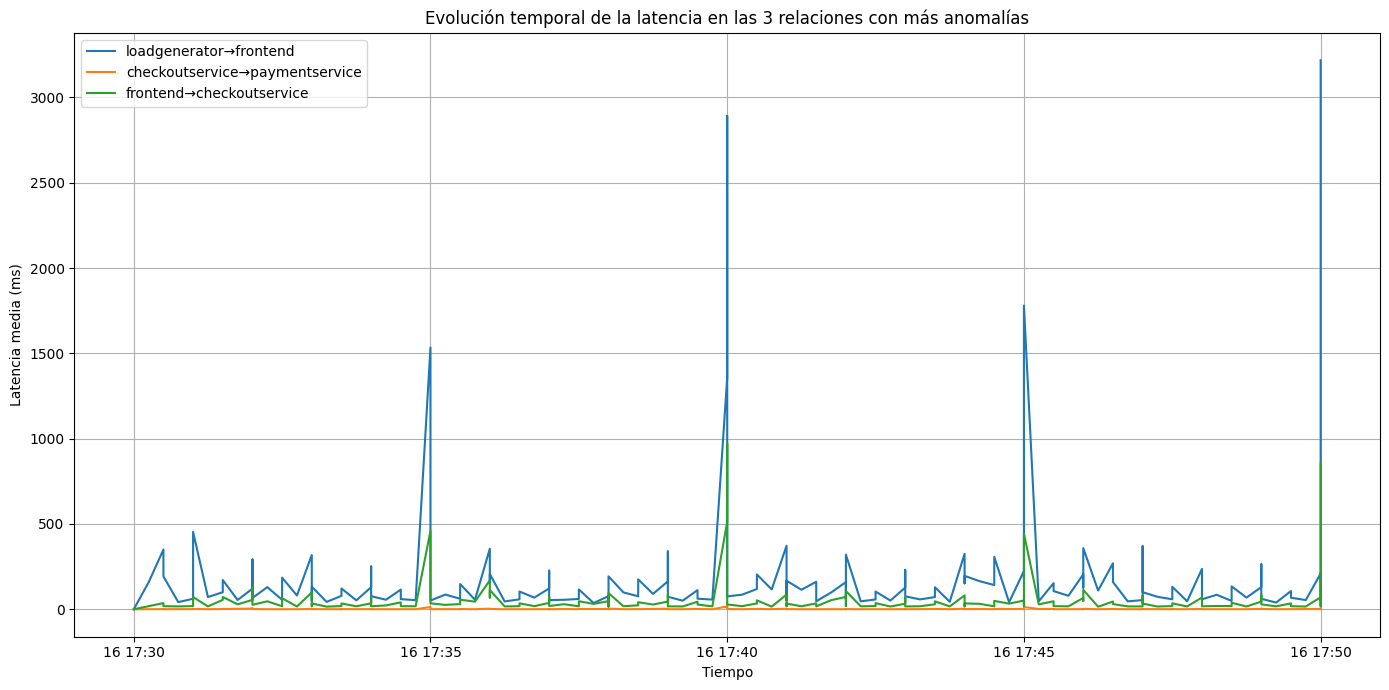

In [8]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv("kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])

# Encontrar el top 3 de relaciones (source→destination) con más anomalías
top3 = (
    df[df["Abnormality class"] != "Normal"]
    .groupby(["source_workload", "destination_workload"])
    .size()
    .sort_values(ascending=False)
    .head(3)
    .index.tolist()
)

plt.figure(figsize=(14, 7))

for src, dst in top3:
    df_rel = df[(df["source_workload"] == src) & (df["destination_workload"] == dst)].sort_values("timestamp")
    plt.plot(df_rel["timestamp"], df_rel["average_latency"], label=f"{src}→{dst}")


plt.title("Evolución temporal de la latencia en las 3 relaciones con más anomalías")
plt.xlabel("Tiempo")
plt.ylabel("Latencia media (ms)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("top3_temporal_latency_graph.png", dpi=200)
plt.show()


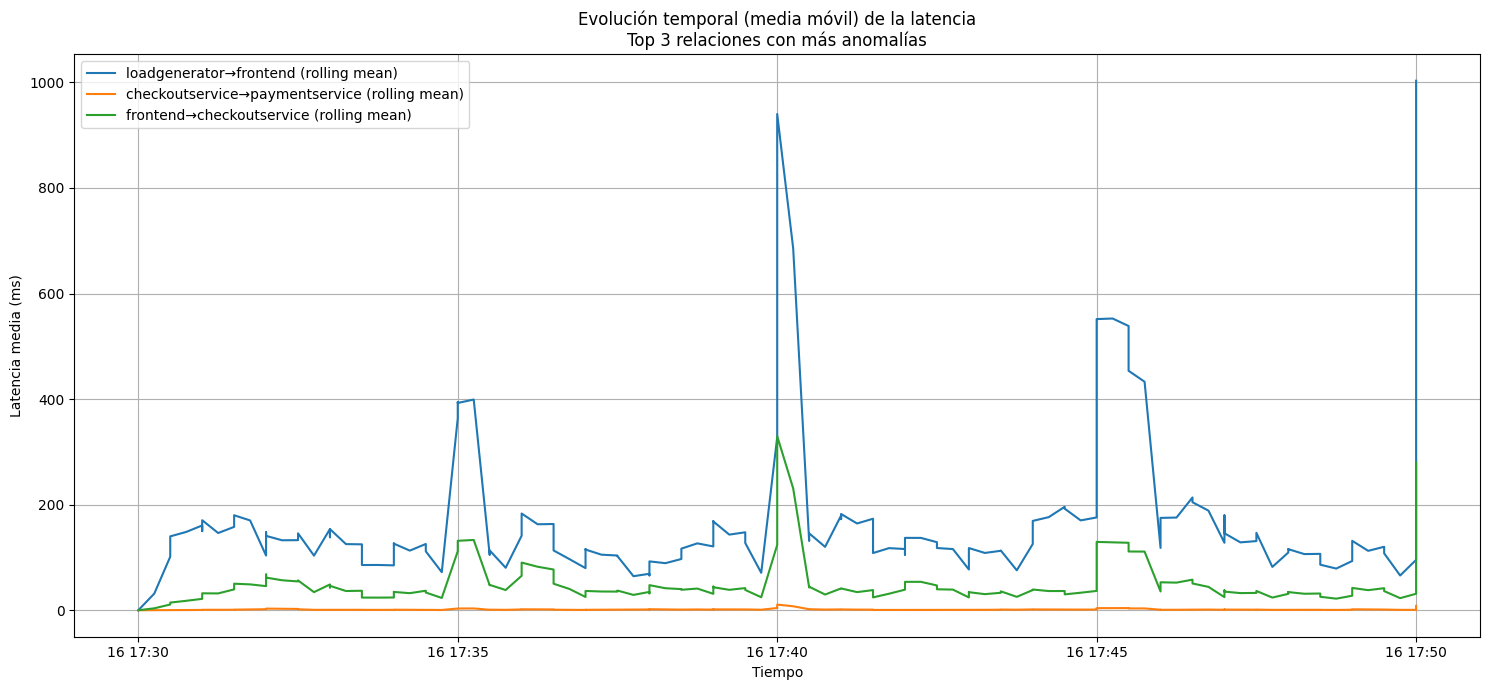

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Cargar el dataset
df = pd.read_csv("kiali_kpi_metrics_processed.csv", parse_dates=["timestamp"])

# Top 3 relaciones (source→destination) con más anomalías
top3 = (
    df[df["Abnormality class"] != "Normal"]
    .groupby(["source_workload", "destination_workload"])
    .size()
    .sort_values(ascending=False)
    .head(3)
    .index.tolist()
)

plt.figure(figsize=(15, 7))

window = 5  # Número de muestras para la media móvil (ajusta según densidad temporal)

for src, dst in top3:
    df_rel = df[(df["source_workload"] == src) & (df["destination_workload"] == dst)].sort_values("timestamp")
    # Calcula rolling mean
    lat_rolling = df_rel["average_latency"].rolling(window=window, min_periods=1).mean()
    plt.plot(df_rel["timestamp"], lat_rolling, label=f"{src}→{dst} (rolling mean)")

    # # Sombrear todas las ventanas anómalas
    # anom_mask = df_rel["Abnormality class"] != "Normal"
    # if anom_mask.any():
    #     # Encuentra todos los intervalos anómalos (por si hay varios)
    #     in_anomaly = False
    #     for i in range(len(df_rel)):
    #         if anom_mask.iloc[i] and not in_anomaly:
    #             start = df_rel["timestamp"].iloc[i]
    #             in_anomaly = True
    #         if in_anomaly and (i == len(df_rel)-1 or not anom_mask.iloc[i+1]):
    #             end = df_rel["timestamp"].iloc[i]
    #             plt.axvspan(start, end, color='red', alpha=0.09)
    #             in_anomaly = False

plt.title("Evolución temporal (media móvil) de la latencia\nTop 3 relaciones con más anomalías")
plt.xlabel("Tiempo")
plt.ylabel("Latencia media (ms)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("top3_temporal_latency_graph_rolling.png", dpi=200)
plt.show()
